# Output from Topic Modeling - Basic Model Validated Including Plots and Tables

### Using smaller model picked by cross-validation: 4 topics (with tfidf transformation)

**How does this notebook work?**

To make it more readable, most of the code is hidden. If you need to see the code or change it, press on the link by `toggle on` at the cell location. While you can't see the code, simple instructions are still displayed above to describe what is happening.

Steps:

    * Load libraries
    * Note: need to install orca for inline interactive plots (frequency plot)
    * May need to download: nltk.download(['punkt', 'stopwords', 'wordnet'])
    
**Important:** to view all possible arguments local modules `helper.helper_funs`, `helper.word_preprocess` and `methods.LDAprep`. Precise definitions can be found there.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # may be a deprecation warning 

import pandas as pd
import numpy as np
from itertools import product

from os import path
import random
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


# local modules
from helper.helper_funs import time_filename, save_folder_file, logged
from helper.word_preprocess import DataLoader, CleanText, WordCount, PlotWords
from methods.LDAprep import GensimPrep, GenMod, Diagnostics, ModelResults 

from helper.dk_ipython import toggled
from IPython.display import HTML
toggled()

## Set parameters:

`seed`: set seed number for reproducibility.

`start`, `max_num_topics`, `step` are for setting topic number (`int`) for cross-validation (lowest topic number, highest, step size)

`col` is for the columns with text. If more than one is chosen, text will be concatenated as one document per art center.

`stop` is to set the language to use for removing words with little meaning (the, a, are, etc.). french is included here because some French may be present even after removing observations labeled as French.

`stop.update` is for adding additional words to be remove, specific to this problem. For example, 'art' is not a meaningful word for our purposes. More words may be added by hand.

**To view the handpicked words removed, click on the `here` link by `toggle on/off`, under the first cell to review the code**

In [2]:
seed = 2018 
random.seed(seed)

# setting for tuning topic number in LDA
eval_every = 5      # the smaller number, the more precise the plot

col = ['Mandate/Mission', 
       'Main Community-Engaged Arts / Arts for Social Change Activities', 
       'Additional Info']  # name of comlumn(s) with text

stop = set(stopwords.words(['english', 'french'])) # words to remove from corpus

stop.update([ 'community', 'use', 'make', 'organization', 'people', 'art', 'arts', 'artist', 'artists',
             'program', 'programs', 'programming', 'programmed', 'provide', 'providing', 'provides',
             'offer', 'offering', 'offered', 'offers', 'center', 'centers', 'centre', 'centres', 'well',
             'youth', 'work', 'workshop', 'workshops', 'working']) # hand picked words to remove



## Load and clean the data

Use the `DataLoader` to load, clean, remove accents, duplicates, empty rows, foreign languages and URLs. Small words (2 letters or less) are removed,then words are shortened and simplified with lemmatization and stemming. Stemming can be changed from `Porter` to `Lancaster` (more conservative) or `Snowball` (language specific).

Result: `processed_data` is a list of lists, containing every unique (stemmed and lemmatized) words in each document.
`pd_data` is a DataFrame with the raw text, for later display.

**Note that the path should be replaced as needed**

In [3]:
data = DataLoader(filename='artbridges_profiles.csv', 
                       data_folder='data',
                       colname=col,  # column(s) to remove weird chars
                       rm_NAs=False, # completely remove records with NaNs 
                                     #(implemented for 1st column only, other cols replace NaN with empty strings and concat)
                       removed_language=['french']) # list of languages to remove (lowercase)

donnee = data.data_loader()  # examples of problem mission statements: â, Lâ 


clean = CleanText(donnee,
                  stop=stop,
                  stemmer='Porter',
                  remove_urls=True)

processed_data = clean.preprocess()

pd_data = pd.DataFrame({'Text': donnee}) # for using unstemmed text later

Reading and cleaning data file...

Removing duplicates in column(s): ['Mandate/Mission', 'Main Community-Engaged Arts / Arts for Social Change Activities', 'Additional Info']...

Removing french words...

Done!


Only plain letters kept and words of 3 letters or more.

63 url(s) removed.


<hr><hr>

## Counting word frequency and plotting

`WordCount` is used to gather `{'word':frequency}` and plot the results. 

In [4]:
wp = WordCount(processed_data)
word_count = wp.dict_count(verbose=0) # verbose: number of documents to show in output

raw_count = WordCount(donnee).count_words()
num_words = sum(list(word_count.values())) # list() optional, depending on python version - ML

print("\nThere are {} words in the combination of all mission statements.".format(raw_count))
print("There are {} words in all statements given (after preprocess).".format(num_words))


There are 28318 words in the combination of all mission statements.
There are 15233 words in all statements given (after preprocess).


## Interactive frequency plot: click to open local server and edit or save plot

Note: a still version of the plot can only be saved if Orca commandline util and psutil library is installed. If Orca is not installed, set `save_plot` argument to `False` to generate the plot with no error.

**To use the plot interactively, click on `export to plot.ly` below.

In [5]:
view_data = PlotWords(word_count)

view_data.freq_plot(top_n=50, save_plot=True) # top_n number of top words to show

Directory does not exist, creating a new directory named /visualization/2018-12-4/...

Pyplot word frequency bar chart saved to `visualization/2018-12-4/word_frequency_barplot_top50_words__8h3m45s.png`.



## Cloud Plot

**Displays the most common (stemmed and lemmatized) words**

Larger words indicate more common words.

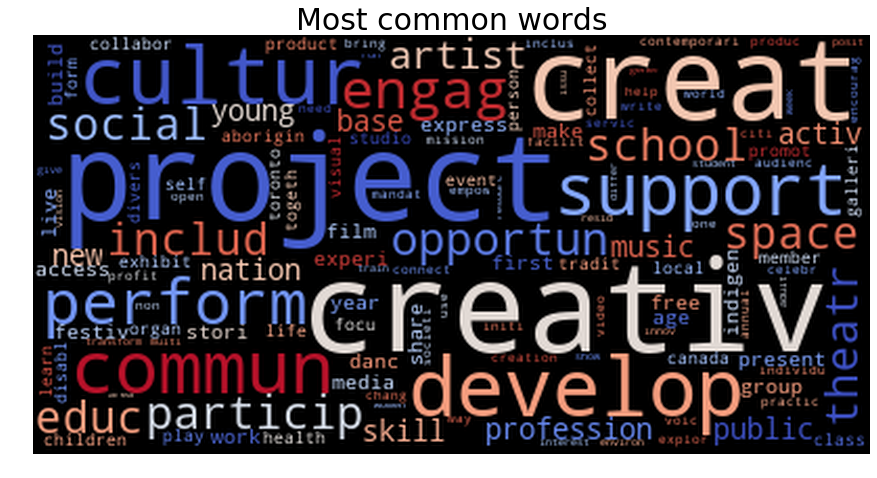

Wordcould plot saved to `visualization/2018-12-4/wordcloud_plot__8h3m55s.png`.



<Figure size 432x288 with 0 Axes>

In [6]:
view_data.cloud_plot(size=(15,12), 
                     max_font_size=60,
                     min_font_size=5);

<hr>

## Final Preparation Before Running LDA (Latent Dirichlet Allocation) Model.

**Additional cleaning**, creating the corpus and bag-of-words format, removing very common words. Saving the resulting corpus.

In [7]:
gp = GensimPrep(processed_data)
lda_dict = gp.gensimDict()

Removing words of less than 3 characters, and words present in at least 0.8% of documents

Removing gaps in indices caused by preprocessing...

Directory does not exist, creating a new directory named /corpus_data/2018-12-4/...

Saving gensim dictionary to corpus_data/2018-12-4/Gensim_dict_Params_MWL3_PD0.8__8h3m56s.dict



In [8]:
print('Number of words processed: {}\n '.format(lda_dict.num_pos))
lda_id = lda_dict.token2id
print('Number of unique words remaining: {}\n\n'.format(max(lda_id.values())))
print('*'*37 + '\n')

bow_rep = gp.gensimBOW(lda_dict)

Number of words processed: 15233
 
Number of unique words remaining: 910


*************************************

Saving .mm matrix to corpus_data/2018-12-4/BOWmat_8h3m56s.mm



## Running Optimized LDA Model 

__*using results from validation process*__

In [9]:
# # Best Tuning Parameters retained:
# {'num_topics': 3, 'alpha': 0.05, 'decay': 0.6}
# {'num_topics': 23, 'alpha': 0.25, 'decay': 0.75}
# {'num_topics': 4, 'alpha': 0.1, 'decay': 0.6}
# {'num_topics': 7, 'alpha': 0.25, 'decay': 0.75}


tfidfTrans = gp.tfidf_trans(bow_rep)

# get_model = GenMod(bow_rep, lda_dict)
get_tfidf = GenMod(tfidfTrans, lda_dict)

# lda_model = get_model.LDA(eval_every=eval_every,
#                           random_state=seed, num_topics= 7, alpha= 0.25, decay= 0.75)

lda_tfidf = get_tfidf.LDA(eval_every=eval_every,
                          random_state=seed, num_topics= 4, alpha= 0.2, decay= 0.7)

Parameters used in model: 
Number of topics: 4
TFIDF transformation: True
Number of iterations: 10000
Batch size: 100
Update every 1 pass
Number of passes: 10
Topic inference per word: True
Alpha: 0.2
Eta: auto
Decay: 0.7
Minimum probability: 0.05
Minimum_phi_value: 0.02
Evaluate every: 5
Random seed: 2018

Directory does not exist, creating a new directory named /saved_models/LDA/2018-12-4/...

Saving LDA model to: 
saved_models/LDA/2018-12-4/LDA_Params_NT4_TFIDFTruePer_word_topicTrue_8h4m5s.model


**Printing** linear combination of keywords for topics.

In [10]:
get_tfidf.print_model(lda_tfidf)

Topic: 1 
Words: 0.005*"perform" + 0.005*"creativ" + 0.004*"project" + 0.004*"school" + 0.004*"cultur" + 0.004*"space" + 0.004*"particip" + 0.004*"opportun" + 0.004*"indigen" + 0.004*"theatr"
Topic: 2 
Words: 0.005*"perform" + 0.005*"creativ" + 0.005*"project" + 0.004*"school" + 0.004*"cultur" + 0.004*"commun" + 0.004*"opportun" + 0.004*"music" + 0.004*"theatr" + 0.004*"space"
Topic: 3 
Words: 0.005*"school" + 0.005*"perform" + 0.005*"creativ" + 0.005*"project" + 0.004*"aborigin" + 0.004*"danc" + 0.004*"space" + 0.004*"public" + 0.004*"particip" + 0.004*"commun"
Topic: 4 
Words: 0.006*"theatr" + 0.005*"perform" + 0.005*"creativ" + 0.004*"school" + 0.004*"cultur" + 0.004*"young" + 0.004*"project" + 0.004*"opportun" + 0.004*"film" + 0.004*"produc"


## Results: diagnostic plots and summary tables

In [11]:
diag = Diagnostics(lda_dict,
                   bow_rep, 
                   processed_data)

warnings.filterwarnings("ignore", category=FutureWarning)

diag.LDAvis(lda_tfidf)

Rendering visualization...
Directory does not exist, creating a new directory named /results/LDAvis_plots/2018-12-4/...



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000064 -0.000942       1        1   5.291618
1     -0.000003  0.000683       2        1   2.025142
2      0.006480  0.000135       3        1  53.806496
3     -0.006541  0.000124       4        1  38.876751, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
48    Default  64.000000   perform  64.000000  30.0000  30.0000
67    Default  60.000000   creativ  60.000000  29.0000  29.0000
88    Default  56.000000   project  56.000000  28.0000  28.0000
91    Default  61.000000    school  61.000000  27.0000  27.0000
6     Default  51.000000    cultur  51.000000  26.0000  26.0000
100   Default  51.000000    theatr  51.000000  25.0000  25.0000
177   Default  49.000000    commun  49.000000  24.0000  24.0000
85    Default  49.000000  opportun  49.000000  23.0000  23.0000
28    Default  48.000000     space  48.000000  22.0000  22.0000
20    Default  47.000000  particip  47.000000  21.0000  21.0000
456   Default  46.000000     music  46.000000  20.0000  20.0000
130   Default  44.000000   indigen  44.000000  19.0000  19.0000
69    Default  48.000000   develop  48.000000  18.0000  18.0000
5     Default  47.000000     creat  47.000000  17.0000  17.0000
60    Default  45.000000    festiv  45.000000  16.0000  16.0000
434   Default  48.000000     young  48.000000  15.0000  15.0000
70    Default  44.000000     engag  44.000000  14.0000  14.0000
113   Default  43.000000      educ  43.000000  13.0000  13.0000
57    Default  46.000000   support  46.000000  12.0000  12.0000
344   Default  43.000000      work  43.000000  11.0000  11.0000
51    Default  44.000000    public  44.000000  10.0000  10.0000
102   Default  42.000000     activ  42.000000   9.0000   9.0000
15    Default  39.000000    includ  39.000000   8.0000   8.0000
142   Default  40.000000    nation  40.000000   7.0000   7.0000
370   Default  43.000000   product  43.000000   6.0000   6.0000
82    Default  34.000000     learn  34.000000   5.0000   5.0000
42    Default  42.000000   galleri  42.000000   4.0000   4.0000
120   Default  34.000000     first  34.000000   3.0000   3.0000
7     Default  41.000000    disabl  41.000000   2.0000   2.0000
290   Default  40.000000   express  40.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
459    Topic4  16.723679     video  35.137329   0.2023  -5.6831
175    Topic4  17.192127  children  36.619598   0.1886  -5.6555
370    Topic4  20.010193   product  43.796085   0.1615  -5.5037
434    Topic4  21.477686     young  48.650963   0.1271  -5.4329
66     Topic4  13.325575  collabor  27.728027   0.2120  -5.9102
67     Topic4  24.968338   creativ  60.222591   0.0643  -5.2823
85     Topic4  21.383795  opportun  49.981350   0.0958  -5.4373
48     Topic4  26.087210   perform  64.633888   0.0375  -5.2385
6      Topic4  21.781532    cultur  51.595688   0.0824  -5.4189
45     Topic4  16.951044     media  38.044945   0.1363  -5.6696
27     Topic4  16.284275    social  36.528656   0.1369  -5.7097
220    Topic4  15.663630      live  34.797394   0.1466  -5.7486
514    Topic4  13.047522    inspir  27.505058   0.1990  -5.9313
247    Topic4  16.242435       new  37.346458   0.1122  -5.7123
177    Topic4  19.946207    commun  49.942375   0.0269  -5.5069
69     Topic4  19.358656   develop  48.046165   0.0358  -5.5368
130    Topic4  17.978554   indigen  44.009811   0.0495  -5.6107
88     Topic4  21.407434   project  56.297523  -0.0221  -5.4362
456    Topic4  18.386293     music  46.081696   0.0260  -5.5883
60     Topic4  18.172846    festiv  45.645229   0.0238  -5.6000
5      Topic4  18.593149     creat  47.280983   0.0115  -5.5771
91     Topic4  21.857458    school  61.530579  -0.0902  -5.4154
104    Topic4  16.017942      base  37.856094   0.0847  -5.7262
102    Topic4  17.119877     activ  42.709297   0

## Tables with Topic Modeling Summary

Tables showing the distribution of words within topics and distribution of topics within documents (1 document = all texts from 1 organization)

**Important:** Topic are numbered starting at 0. For example, if we have 4 topics, they will be numbered from 0 to 3.

<hr>

### Table 1: Show Most Important Topic in each Document.

Displays the topic number that contributes most to document (in terms of marginal probability). Very high probability (close to 1) indicates that the topics are apparently easily distinguished from one another. 

Only 20 documents are displayed below, but all organizations with non-empty text are gathered in this table.

In [12]:
mod_res = ModelResults(lda_tfidf, bow_rep, donnee)

df_dominant_topic = mod_res.format_topics_sentences()

small_dom_topic = pd.concat([df_dominant_topic.Dominant_Topic, 
                             df_dominant_topic.Percent_Contribution, 
                             df_dominant_topic.Important_Keywords,
                             df_dominant_topic.Mission], axis = 1)

small_dom_topic.columns = ['Dominant_Topic', 'Percent_Contribution', 'Important_Keywords', 'Mission']

small_dom_topic.head(15)

Directory does not exist, creating a new directory named /results/2018-12-4/...

Saving the table to: results/2018-12-4/dominant_topic_per_text__8h4m19s.csv


,Dominant_Topic,Percent_Contribution,Important_Keywords,Mission
0,3.0,0.9828,"theatr, perform, creativ, school, cultur, youn...",our goal is to have the space become self-sust...
1,2.0,0.9833,"school, perform, creativ, project, aborigin, d...",white water gallery is a not-for-profit artist...
2,3.0,0.8389,"theatr, perform, creativ, school, cultur, youn...",women sweetgrass film festival 2011
3,3.0,0.9900,"theatr, perform, creativ, school, cultur, youn...",(in development):\n\n -to provide appropriat...
4,3.0,0.9096,"theatr, perform, creativ, school, cultur, youn...",to create original physical theatre. to share ...
5,2.0,0.9946,"school, perform, creativ, project, aborigin, d...",the woodland cultural centre is a first nation...
6,3.0,0.9519,"theatr, perform, creativ, school, cultur, youn...",to provide an open and supportive environment ...
7,2.0,0.9940,"school, perform, creativ, project, aborigin, d...",the mandate of the 4cs foundation is to build ...
8,3.0,0.9828,"theatr, perform, creativ, school, cultur, youn...","4elements living arts is a multidisciplinary, ..."
9,2.0,0.9866,"school, perform, creativ, project, aborigin, d...",7th generation image makers is a community art...


<hr>

### Table 2: Most Important Document/Text for each Topic

These are the documents that were most clealy classified into a given topic.

In [13]:
tab = mod_res.top_texts_per_topic(df_dominant_topic)

tab = pd.concat([tab.Dominant_Topic, 
                             tab.Percent_Contribution, 
                             tab.Important_Keywords,
                             tab.Mission], axis = 1)

tab.columns = ['Dominant_Topic', 'Percent_Contribution', 'Important_Keywords', 'Mission']
tab

Saving the table to: results/2018-12-4/top_texts_per_topic_8h4m19s.csv


,Dominant_Topic,Percent_Contribution,Important_Keywords,Mission
0,0.0,0.9956,"perform, creativ, project, school, cultur, spa...","founded in 1987, canadian stage is one of the ..."
1,1.0,0.9868,"perform, creativ, project, school, cultur, com...",to create community mural projects with youth....
2,2.0,0.9972,"school, perform, creativ, project, aborigin, d...",hamilton youth poets (hyp) was created in 2012...
3,3.0,0.9968,"theatr, perform, creativ, school, cultur, youn...",our mission\n\nfounded in 2014 by matt white a...


### Table 3: How documents are distributed between topics

In [14]:
top_dist = mod_res.topic_distribution(df_dominant_topic, tab)

top_dist

Saving the table to: results/2018-12-4/doc_distribution_in_topics_8h4m19s.csv


,Dominant_Topic,Important_Keywords,Num_Documents,Perc_Documents
0,0.0,"perform, creativ, project, school, cultur, spa...",18,0.07826
1,1.0,"perform, creativ, project, school, cultur, com...",7,0.03043
2,2.0,"school, perform, creativ, project, aborigin, d...",116,0.50435
3,3.0,"theatr, perform, creativ, school, cultur, youn...",89,0.38696


<hr>
<hr>

## Update Corpus with BC Specific Data

Update the trained model with additional data from the BC dataset, using the `Mission/Mandate` and `Additional Info` columns.

In [15]:
col2 = ['Mandate/Mission', 
       'Additional Info']  

data2 = DataLoader(filename='artbridges_test.csv', 
                       data_folder='data',
                       colname=col2,  # column(s) to remove weird chars
                       rm_NAs=False, # completely remove records with NaNs 
                                     #(implemented for 1st column only, other cols replace NaN with empty strings and concat)
                       removed_language=['french']) # list of languages to remove (lowercase)

donnee2 = data2.data_loader()  # examples of problem mission statements: â, Lâ 


clean2 = CleanText(donnee2,
                  stop=stop,
                  stemmer='Porter',
                  remove_urls=True)

processed_data2 = clean2.preprocess()

pd_data2 = pd.DataFrame({'Text': donnee2}) # for using unstemmed text later

Reading and cleaning data file...

Removing duplicates in column(s): ['Mandate/Mission', 'Additional Info']...

Removing french words...

Done!


Only plain letters kept and words of 3 letters or more.

9 url(s) removed.


In [16]:
gp2 = GensimPrep(processed_data2)
lda_dict2 = gp2.gensimDict()
lda_id2 = lda_dict2.token2id
bow_rep2 = gp2.gensimBOW(lda_dict2)


tfidfTrans2 = gp2.tfidf_trans(bow_rep2)

Removing words of less than 3 characters, and words present in at least 0.8% of documents

Removing gaps in indices caused by preprocessing...

Saving gensim dictionary to corpus_data/2018-12-4/Gensim_dict_Params_MWL3_PD0.8__8h4m30s.dict

Saving .mm matrix to corpus_data/2018-12-4/BOWmat_8h4m30s.mm



In [17]:
# Create a new corpus, made of previously unseen documents.

other_corpus = [lda_dict2.doc2bow(text) for text in processed_data2]

lda_tfidf.update(other_corpus)

In [18]:
diag2 = Diagnostics(lda_dict2,
                   bow_rep2, 
                   processed_data2)

warnings.filterwarnings("ignore", category=FutureWarning)

diag.LDAvis(lda_tfidf)

Rendering visualization...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.048269  0.008163       1        1  68.582283
1      0.047706  0.008138       2        1  26.871109
2     -0.063478  0.042349       3        1   1.600691
3     -0.032497 -0.058650       4        1   2.945922, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
104   Default   87.000000          base   87.000000  30.0000  30.0000
10    Default   85.000000        experi   85.000000  29.0000  29.0000
20    Default  100.000000      particip  100.000000  28.0000  28.0000
62    Default   82.000000         women   82.000000  27.0000  27.0000
120   Default   92.000000         first   92.000000  26.0000  26.0000
97    Default   70.000000        origin   70.000000  25.0000  25.0000
51    Default   73.000000        public   73.000000  24.0000  24.0000
54    Default   56.000000         round   56.000000  23.0000  23.0000
130   Default   76.000000       indigen   76.000000  22.0000  22.0000
18    Default   61.000000          need   61.000000  21.0000  21.0000
48    Default   85.000000       perform   85.000000  20.0000  20.0000
29    Default   55.000000       sustain   55.000000  19.0000  19.0000
21    Default   51.000000         popul   51.000000  18.0000  18.0000
92    Default   70.000000        studio   70.000000  17.0000  17.0000
25    Default   48.000000        sexual   48.000000  16.0000  16.0000
148   Default   68.000000       present   68.000000  15.0000  15.0000
110   Default   35.000000         close   35.000000  14.0000  14.0000
38    Default   62.000000  contemporari   62.000000  13.0000  13.0000
118   Default   38.000000        extens   38.000000  12.0000  12.0000
58    Default   59.000000    understand   59.000000  11.0000  11.0000
50    Default   52.000000        profit   52.000000  10.0000  10.0000
106   Default   38.000000          bead   38.000000   9.0000   9.0000
95    Default   59.000000        visual   59.000000   8.0000   8.0000
24    Default   59.000000          self   59.000000   7.0000   7.0000
45    Default   63.000000         media   63.000000   6.0000   6.0000
113   Default   61.000000          educ   61.000000   5.0000   5.0000
85    Default   69.000000      opportun   69.000000   4.0000   4.0000
89    Default   47.000000       resourc   47.000000   3.0000   3.0000
165   Default   35.000000         think   35.000000   2.0000   2.0000
67    Default   71.000000       creativ   71.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
133    Topic4    2.421510     interpret   26.635857   1.1269  -5.0356
31     Topic4    1.960837          wide   21.951216   1.1093  -5.2466
145    Topic4    2.531021         paint   29.473375   1.0699  -4.9913
184    Topic4    2.028823          full   25.100880   1.0093  -5.2125
2      Topic4    1.778237         becom   22.241480   0.9984  -5.3443
86     Topic4    2.286865   partnership   28.807941   0.9913  -5.0928
137    Topic4    1.523447          line   19.528360   0.9739  -5.4990
62     Topic4    6.402146         women   82.694847   0.9662  -4.0633
63     Topic4    2.079791        afford   27.433533   0.9452  -5.1877
146    Topic4    1.545902          past   21.305592   0.9014  -5.4843
44     Topic4    2.601983          juli   36.000481   0.8975  -4.9637
57     Topic4    3.715402       support   55.683998   0.8175  -4.6075
93     Topic4    2.673817          team   37.947521   0.8721  -4.9364
135    Topic4    3.219795       languag   49.204876   0.7981  -4.7506
24     Topic4    3.597070          self   59.022026   0.7270  -4.6398
43     Topic4    2.990050         innov   44.930565   0.8149  -4.8247
92     Topic4    3.880444        studio   70.520584   0.6248  -4.5640
120    Topic4    4.498912         first   92.370369   0.5028  -4.4161
58     Topic4    3.419629    understand   59.640663   0.6659  -

__*Note: Looking at the words from the BC dataset, the words appear to be noticeably different and do not seem to improve the model fit.*__